# ASL Image Data Loader & Augmentation Setup(Feasibility)

This notebook sets up a small subset of the ASL Alphabet dataset for transfer learning.

Steps:
- Download and use the ASL dataset using `kagglehub`
- Work with just 5 common letters in English: E, A, R, I, O
- Limit each class to under 100 images
- Prepare training and validation loaders


In [64]:
import kagglehub
from pathlib import Path
import os

# ✅ Download the dataset
dataset_path = kagglehub.dataset_download("grassknoted/asl-alphabet")
print("Top-level path:", dataset_path)

# ✅ Convert to Path object for safe path joins
dataset_path = Path(dataset_path)

# ✅ Navigate to the nested folder that contains the actual letter folders
nested_path = dataset_path / "asl_alphabet_train" / "asl_alphabet_train"

# ✅ Check what’s inside to confirm correct path
print("Nested training folder path:", nested_path)
print("Available letters:", sorted(os.listdir(nested_path)))


Top-level path: /kaggle/input/asl-alphabet
Nested training folder path: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train
Available letters: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


## Dataset Overview

The ASL Alphabet dataset includes folders for each letter (A–Z), plus a few extra labels.

For this assignment, we are using a subset of just 5 letters:  
**['E', 'A', 'R', 'I', 'O']**

We'll take up to 80 images per class and split them into training and validation sets. This keeps the dataset small and easy to use for transfer learning.

## Prepare Subset with 5 Letters

We’ll now create a smaller dataset using just the letters: **E, A, R, I, O**.

For each class:
- We’ll randomly pick 80 images
- Split them into training (56) and validation (24)
- Save them in a new folder: `asl_subset/train/` and `asl_subset/val/`


In [65]:
import os, shutil, random
from pathlib import Path

# ✅ Use the verified nested path from previous cell
original_data_path = dataset_path / "asl_alphabet_train" / "asl_alphabet_train"

# ✅ Define subset path and target letters
subset_root = Path("asl_subset")
selected_letters = ['E', 'A', 'R', 'I', 'O']
train_dir = subset_root / "train"
val_dir = subset_root / "val"

# ✅ Recreate subset folders
for split_dir in [train_dir, val_dir]:
    if split_dir.exists():
        shutil.rmtree(split_dir)
    for letter in selected_letters:
        (split_dir / letter).mkdir(parents=True, exist_ok=True)

# ✅ Copy 80 images per letter, split into 56 train / 24 val
for letter in selected_letters:
    src = original_data_path / letter
    if not src.exists():
        print(f"❌ Missing folder: {src}")
        continue

    images = list(src.glob("*.jpg"))
    if len(images) < 80:
        print(f"⚠️ Not enough images in '{letter}', only {len(images)} found.")
        continue

    random.shuffle(images)
    selected_images = images[:80]
    train_images = selected_images[:56]
    val_images = selected_images[56:]

    for img in train_images:
        shutil.copy(img, train_dir / letter)
    for img in val_images:
        shutil.copy(img, val_dir / letter)

# ✅ Print counts
for name, split_dir in [("TRAIN", train_dir), ("VAL", val_dir)]:
    print(f"\n{name} SET")
    for letter in selected_letters:
        count = len(list((split_dir / letter).glob("*.jpg")))
        print(f"{letter}: {count} images")



TRAIN SET
E: 56 images
A: 56 images
R: 56 images
I: 56 images
O: 56 images

VAL SET
E: 24 images
A: 24 images
R: 24 images
I: 24 images
O: 24 images


## Load and Visualize Subset

Using Keras `ImageDataGenerator` to load the subset and visualize a few sample images.
to confirm that:
- Images are being read correctly
- Labels match the folder names
- Class distribution looks good


In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Define image shape and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# Data generators (no augmentation for now)
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    directory="asl_subset/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    directory="asl_subset/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 280 images belonging to 5 classes.
Found 120 images belonging to 5 classes.


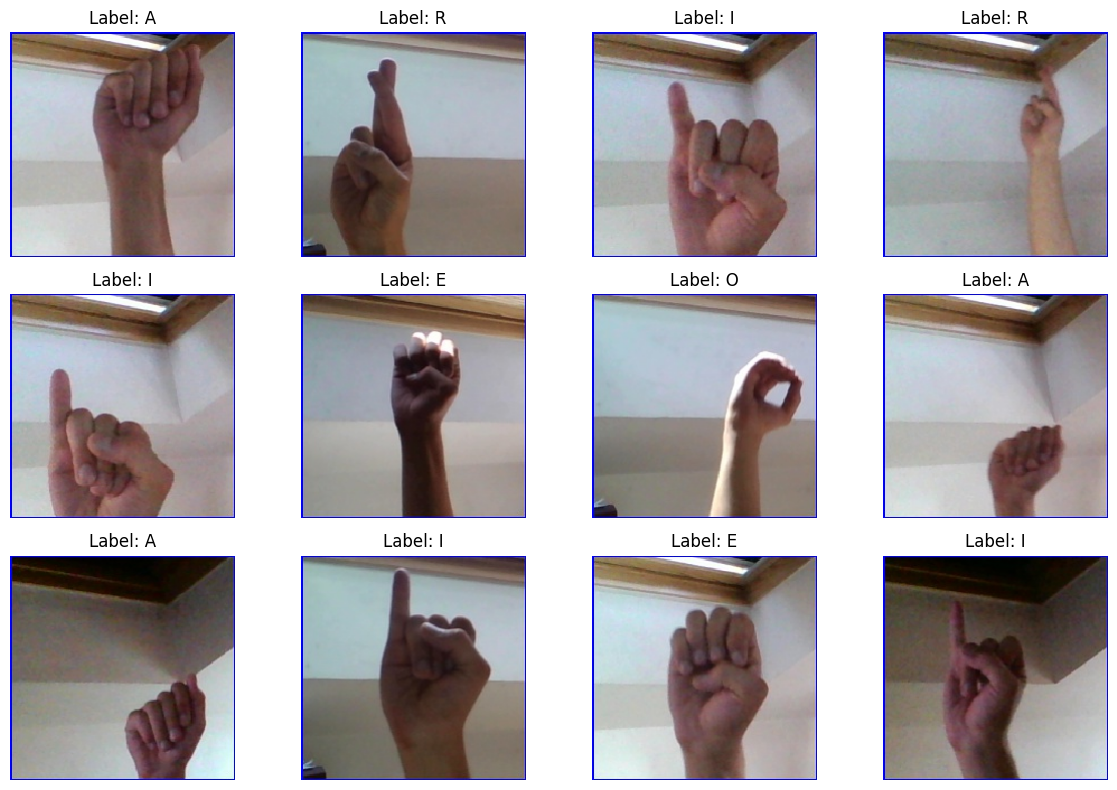

In [68]:
# Get 1 batch of images and labels
images, labels = next(train_generator)

# Create index-to-label mapping
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}

# Plot images with labels
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])
    plt.title(f"Label: {idx_to_class[label_idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# TrainBaseModel.ipynb  
## 1. Train a Baseline Transfer Learning Model

In this section, we:
- Load a pretrained model from Keras (transfer learning)
- Add a few custom layers on top
- Train on our ASL subset
- Save the trained model for reuse


In [69]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Reuse your IMG_SIZE and BATCH_SIZE
IMG_SIZE = (224, 224)
INPUT_SHAPE = IMG_SIZE + (3,)


# Load base MobileNetV2 model without top layers
base_model = MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model

# Build model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')  # 5 classes: A, E, R, I, O
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Train the Baseline Model

We’ll now train our model on the ASL subset using:
- 10 epochs
- Training and validation data from our image generators
We’ll plot accuracy and loss curves to evaluate performance.


In [70]:
# Train the Baseline Model
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 888ms/step - accuracy: 0.3710 - loss: 1.5959 - val_accuracy: 0.7583 - val_loss: 0.7170
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 793ms/step - accuracy: 0.8231 - loss: 0.5580 - val_accuracy: 0.8917 - val_loss: 0.3711
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 845ms/step - accuracy: 0.9330 - loss: 0.2316 - val_accuracy: 0.9250 - val_loss: 0.2441
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 780ms/step - accuracy: 0.9871 - loss: 0.1263 - val_accuracy: 0.9417 - val_loss: 0.2324
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 760ms/step - accuracy: 0.9756 - loss: 0.0978 - val_accuracy: 0.9417 - val_loss: 0.1886
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 761ms/step - accuracy: 0.9909 - loss: 0.0721 - val_accuracy: 0.9333 - val_loss: 0.2022
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 761ms/step - accuracy: 0.9853 - loss: 0.0577 - val_accuracy: 0.9250 - val_loss: 0.1862
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 849ms/step - accuracy: 0.9992 - loss: 0.0394 - val_accuracy: 0.966

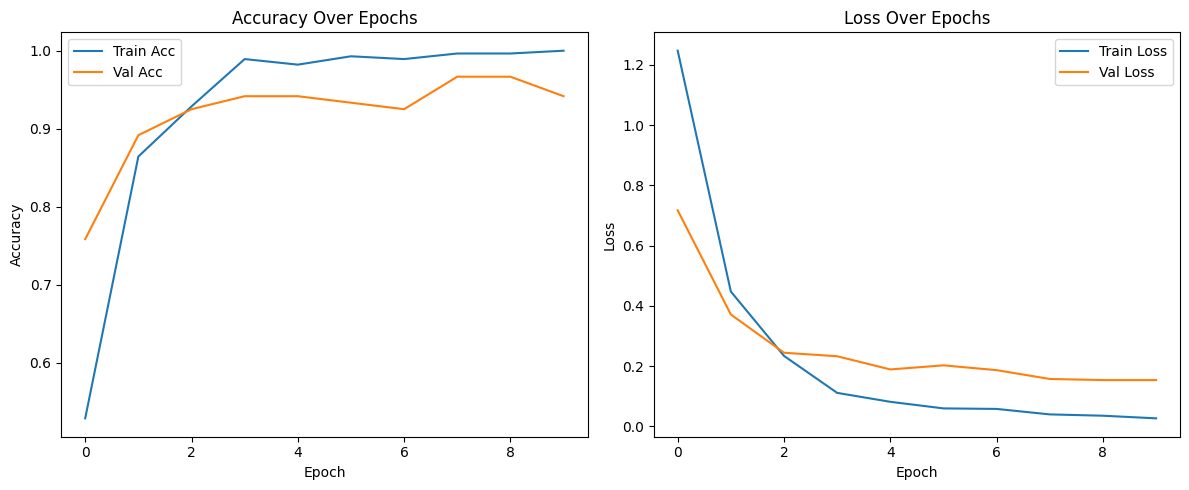

In [71]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



## Save the Trained Baseline Model

We’ll save the trained MobileNetV2-based model using `model.save()`, so we can reuse it later or compare it with other models.

In [72]:
model.save("baseline_model.keras")

In [73]:
import os

# Count files in each train class
for letter in selected_letters:
    folder = Path("asl_subset/train") / letter
    files = list(folder.glob("*"))
    print(f"{letter}: {len(files)} images")


E: 56 images
A: 56 images
R: 56 images
I: 56 images
O: 56 images


### 2. TrainBaseModelAugmentation.ipynb
Add image augmentations to increase variety in our training data and potentially improve generalization by:

- Applyiing at least **3 augmentations** **bold text**
- Retraining the model
- Saving the new model for comparison


In [74]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create new augmented training generator
augmented_train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,        # Augmentation 1: Rotate images
    width_shift_range=0.1,    # 2: Horizontal shift
    zoom_range=0.1,           # 3: Zoom in
    horizontal_flip=True      # 4: Flip images horizontally
).flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Validation generator stays the same (no augmentation)

Found 280 images belonging to 5 classes.


###  Visualize Augmented Samples

Let's preview a few augmented images from our new generator to verify it looks good.

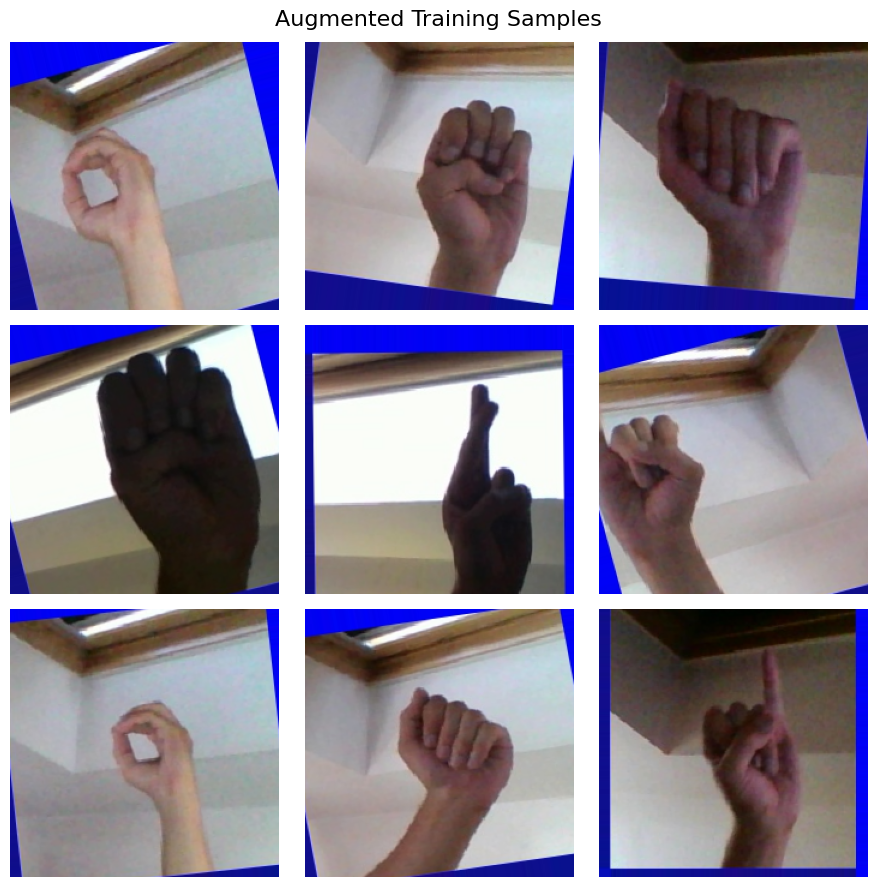

In [75]:
import matplotlib.pyplot as plt

# Show 9 augmented images
aug_images, aug_labels = next(augmented_train_generator)

plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(aug_images[i])
    plt.axis('off')
plt.suptitle("Augmented Training Samples", fontsize=16)
plt.tight_layout()
plt.show()

##  Retrain the Model with Data Augmentation
Retrain the same model architecture using the augmented training data and compare its performance to the baseline.


In [76]:
# Train the same model architecture using augmented data
EPOCHS = 10

history_aug = model.fit(
    augmented_train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 950ms/step - accuracy: 0.8605 - loss: 0.3254 - val_accuracy: 0.9167 - val_loss: 0.2548
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 997ms/step - accuracy: 0.9101 - loss: 0.3018 - val_accuracy: 0.9333 - val_loss: 0.1957
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 899ms/step - accuracy: 0.9671 - loss: 0.1417 - val_accuracy: 0.9417 - val_loss: 0.1855
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 893ms/step - accuracy: 0.9741 - loss: 0.1303 - val_accuracy: 0.9167 - val_loss: 0.2578
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 905ms/step - accuracy: 0.9616 - loss: 0.1131 - val_accuracy: 0.9000 - val_loss: 0.3123
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 922ms/step - accuracy: 0.9267 - loss: 0.1536 - val_accuracy: 0.9500 - val_loss: 0.1871
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 893ms/step - accuracy: 0.9696 - loss: 0.1107 - val_accuracy: 0.9250 - val_loss: 0.2018
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 980ms/step - accuracy: 0.9814 - loss: 0.1079 - val_accu

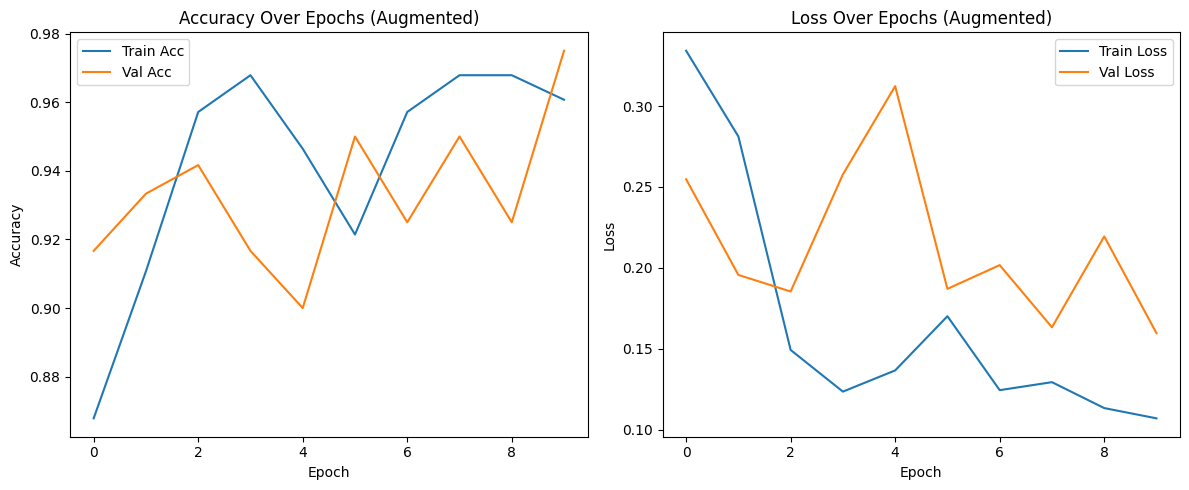

In [77]:
# Plot accuracy and loss for the augmented training
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_aug.history['accuracy'], label='Train Acc')
plt.plot(history_aug.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs (Augmented)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_aug.history['loss'], label='Train Loss')
plt.plot(history_aug.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs (Augmented)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [78]:
model.save("augmented_model.keras")
print("Model saved in Keras format as augmented_model.keras")


Model saved in Keras format as augmented_model.keras


## 3. CompareAugmentation.ipynb:
- Goal: Test if data augmentation helped
- Task: Load the two models and compare their ROC curves



In [79]:
# Import libraries
from sklearn.metrics import roc_curve, auc
import numpy as np
# Load the saved models
baseline_model = tf.keras.models.load_model("baseline_model.keras")
augmented_model = tf.keras.models.load_model("augmented_model.keras")


In [80]:
# Get all validation data
val_images = []
val_labels = []

for i in range(len(val_generator)):
    batch_images, batch_labels = val_generator[i]
    val_images.append(batch_images)
    val_labels.append(batch_labels)

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

In [81]:
# Get predicted probabilities
baseline_probs = baseline_model.predict(val_images)
augmented_probs = augmented_model.predict(val_images)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


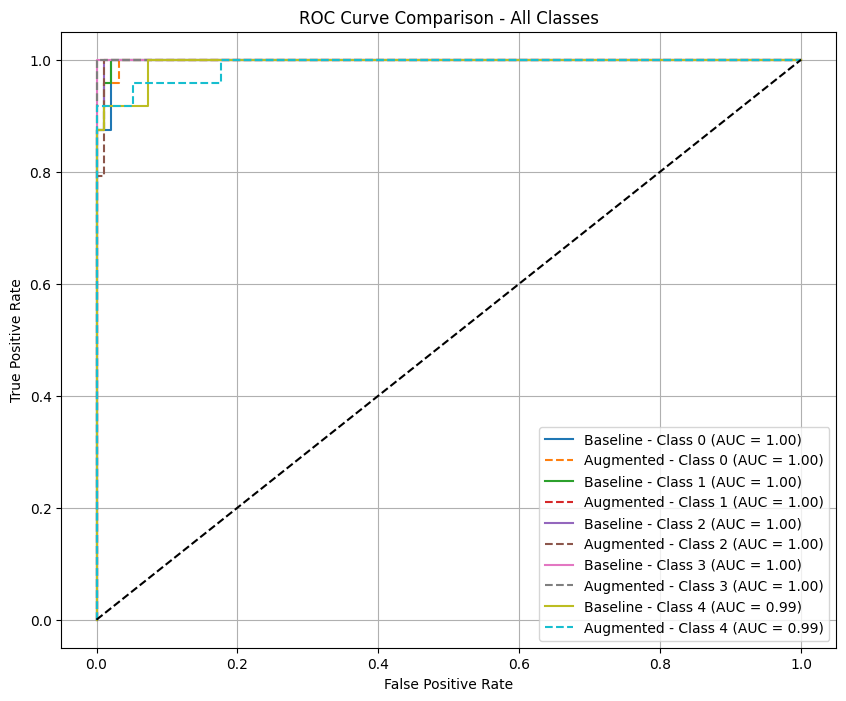

In [82]:
# Get number of classes
num_classes = val_labels.shape[1]

plt.figure(figsize=(10, 8))

for class_index in range(num_classes):
    # Flatten one-hot labels
    val_labels_flat = val_labels[:, class_index]

    # ROC for baseline model
    fpr_base, tpr_base, _ = roc_curve(val_labels_flat, baseline_probs[:, class_index])
    auc_base = auc(fpr_base, tpr_base)

    # ROC for augmented model
    fpr_aug, tpr_aug, _ = roc_curve(val_labels_flat, augmented_probs[:, class_index])
    auc_aug = auc(fpr_aug, tpr_aug)

    # Plot
    plt.plot(fpr_base, tpr_base, label=f"Baseline - Class {class_index} (AUC = {auc_base:.2f})")
    plt.plot(fpr_aug, tpr_aug, linestyle='--', label=f"Augmented - Class {class_index} (AUC = {auc_aug:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison - All Classes")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


###4. TrainModel2.ipynb (EfficientNetB0)
## Train EfficientNetB0 Transfer Learning Model

In this notebook, we implement a transfer learning pipeline using EfficientNetB0 from Keras Applications.
We'll:
- Load EfficientNetB0 with ImageNet weights
- Freeze the base model and train a custom classification head
- Save the trained model for comparison with others


In [83]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Get number of classes from generator
num_classes = train_generator.num_classes

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Compile full model
model_effnet = Model(inputs=base_model.input, outputs=output)
model_effnet.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model
history_effnet = model_effnet.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Save model
model_effnet.save("efficientnet_model.keras")
print("EfficientNetB0 model saved as efficientnet_model.keras")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.2250 - loss: 1.6649 - val_accuracy: 0.2000 - val_loss: 1.6268
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.2151 - loss: 1.6161 - val_accuracy: 0.2000 - val_loss: 1.6169
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2099 - loss: 1.6216 - val_accuracy: 0.2000 - val_loss: 1.6107
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.1550 - loss: 1.6463 - val_accuracy: 0.2000 - val_loss: 1.6098
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2565 - loss: 1.6122 - val_accuracy: 0.2000 - val_loss: 1.6096
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1868 - loss: 1.6158 - val_accuracy: 0.2000 - val_loss: 1.6098
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.1602 - loss: 1.6230 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.205

###5. TrainModel3.ipynb
## Train MobileNetV2 Transfer Learning Model

In this section, we implement a transfer learning pipeline using **MobileNetV2** from Keras Applications. We'll:

- Load MobileNetV2 with ImageNet weights
- Freeze the base model and add a custom classification head
- Train the model and save it for comparison with others


In [84]:
# Load MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Get number of classes from generator
num_classes = train_generator.num_classes

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Compile full model
model_mobile = Model(inputs=base_model.input, outputs=output)
model_mobile.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [85]:
# Train MobileNetV2 model
history_mobile = model_mobile.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Save model
model_mobile.save("mobilenetv2_model.keras")
print("MobileNetV2 model saved as mobilenetv2_model.keras")


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 903ms/step - accuracy: 0.2512 - loss: 1.9187 - val_accuracy: 0.2333 - val_loss: 1.6447
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 747ms/step - accuracy: 0.2866 - loss: 1.7241 - val_accuracy: 0.2917 - val_loss: 1.5347
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 791ms/step - accuracy: 0.3090 - loss: 1.6589 - val_accuracy: 0.3500 - val_loss: 1.4502
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 839ms/step - accuracy: 0.2913 - loss: 1.5180 - val_accuracy: 0.4000 - val_loss: 1.3741
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 773ms/step - accuracy: 0.4215 - loss: 1.4316 - val_accuracy: 0.4583 - val_loss: 1.3062
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 823ms/step - accuracy: 0.4157 - loss: 1.3719 - val_accuracy: 0.5250 - val_loss: 1.2424
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 778ms/step - accuracy: 0.5090 - loss: 1.2626 - val_accuracy: 0.5833 - val_loss: 1.1821
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 761ms/step - accuracy: 0.4423 - loss: 1.2565 - val_accu

### 6. CompareModels.ipynb
## Compare Trained Models with ROC Curves

In [86]:
# Load saved models
model_baseline = tf.keras.models.load_model("baseline_model.keras")
model_augmented = tf.keras.models.load_model("augmented_model.keras")
model_mobilenet = tf.keras.models.load_model("mobilenetv2_model.keras")

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 802ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 632ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 739ms/step


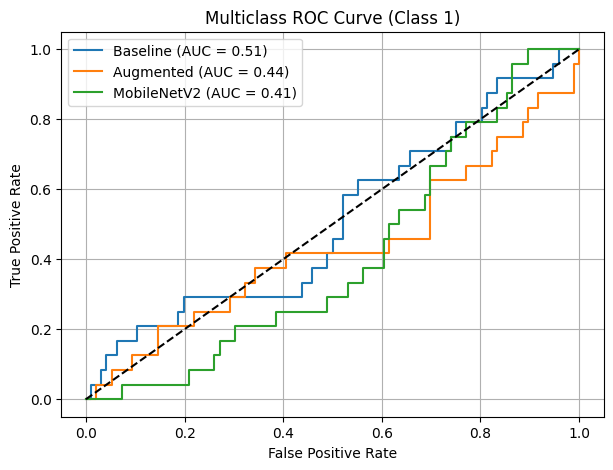

In [87]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Get true labels and number of classes
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

def compute_multiclass_roc(model):
    y_score = model.predict(val_generator)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

# Compute curves
fpr_b, tpr_b, auc_b = compute_multiclass_roc(model_baseline)
fpr_a, tpr_a, auc_a = compute_multiclass_roc(model_augmented)
fpr_m, tpr_m, auc_m = compute_multiclass_roc(model_mobilenet)

# Plot micro-average or class 1 as example
plt.figure(figsize=(7,5))
plt.plot(fpr_b[1], tpr_b[1], label=f'Baseline (AUC = {auc_b[1]:.2f})')
plt.plot(fpr_a[1], tpr_a[1], label=f'Augmented (AUC = {auc_a[1]:.2f})')
plt.plot(fpr_m[1], tpr_m[1], label=f'MobileNetV2 (AUC = {auc_m[1]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (Class 1)')
plt.legend()
plt.grid(True)
plt.show()


###Visualizations

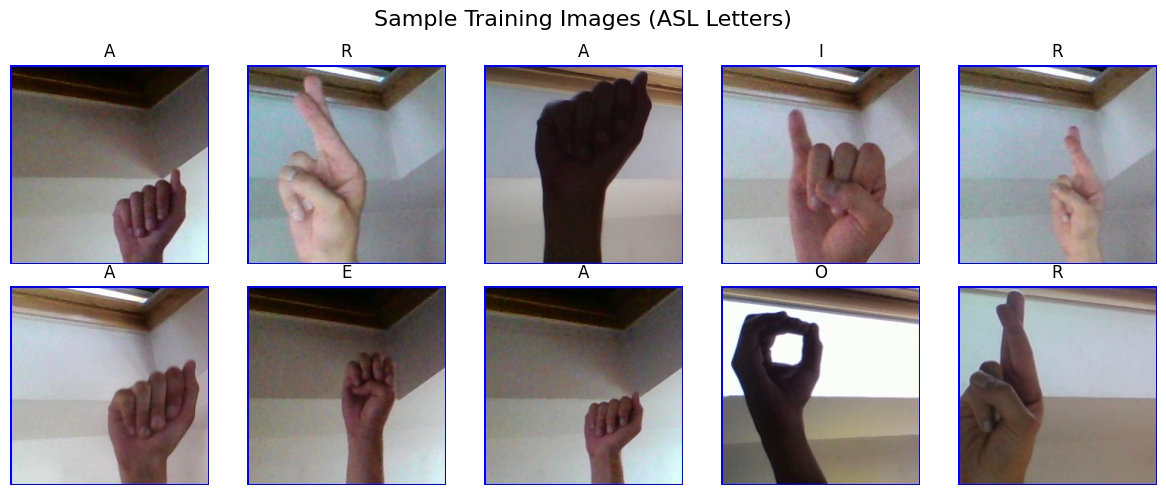

In [89]:
import matplotlib.pyplot as plt
import random
from pathlib import Path
from PIL import Image

# Adjust to your actual training path
sample_path = Path("asl_subset/train")
letters = ['E', 'A', 'R', 'I', 'O']
n_rows, n_cols = 2, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 5))

for i in range(n_rows * n_cols):
    letter = random.choice(letters)
    img_path = random.choice(list((sample_path / letter).glob("*.jpg")))
    img = Image.open(img_path)
    ax = axs[i // n_cols, i % n_cols]
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(letter)

plt.suptitle("Sample Training Images (ASL Letters)", fontsize=16)
plt.tight_layout()
plt.show()



In [90]:
plt.savefig("roc_curve_all_classes.png")


<Figure size 640x480 with 0 Axes>

In [95]:
history_baseline = model_baseline.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 973ms/step - accuracy: 1.0000 - loss: 0.0256 - val_accuracy: 0.9583 - val_loss: 0.1456
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9990 - loss: 0.0120 - val_accuracy: 0.9333 - val_loss: 0.1600
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 789ms/step - accuracy: 0.9919 - loss: 0.0281 - val_accuracy: 0.9583 - val_loss: 0.1659
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 773ms/step - accuracy: 1.0000 - loss: 0.0170 - val_accuracy: 0.9500 - val_loss: 0.1625
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 848ms/step - accuracy: 0.9931 - loss: 0.0196 - val_accuracy: 0.9667 - val_loss: 0.1467
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 765ms/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 0.9083 - val_loss: 0.2999
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 855ms/step - accuracy: 0.9936 - loss: 0.0239 - val_accuracy: 0.9583 - val_loss: 0.1469
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 844ms/step - accuracy: 1.0000 - loss: 0.0147 - val_accurac

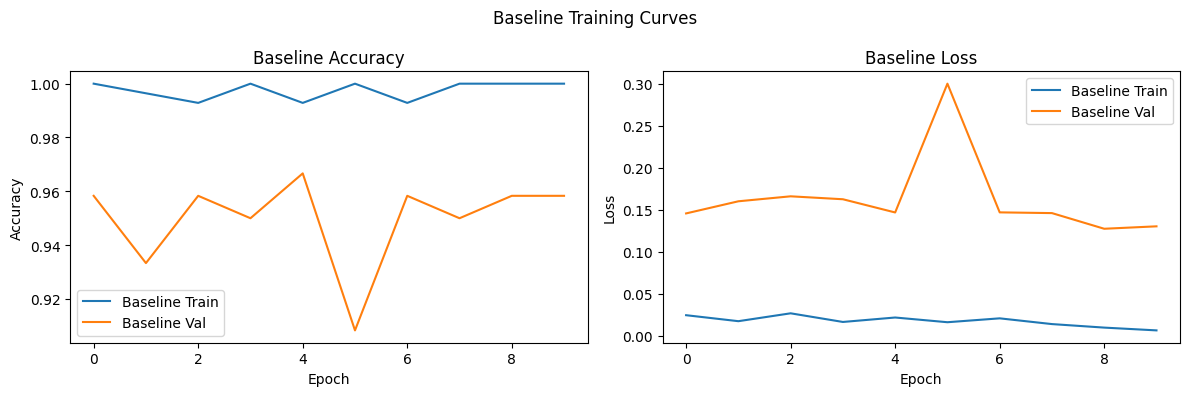

In [96]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['accuracy'], label='Baseline Train')
plt.plot(history_baseline.history['val_accuracy'], label='Baseline Val')
plt.title('Baseline Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['loss'], label='Baseline Train')
plt.plot(history_baseline.history['val_loss'], label='Baseline Val')
plt.title('Baseline Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("Baseline Training Curves")
plt.tight_layout()
plt.savefig("baseline_training_curves.png")
plt.show()


In [98]:
pred = model_augmented.predict(val_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 698ms/step


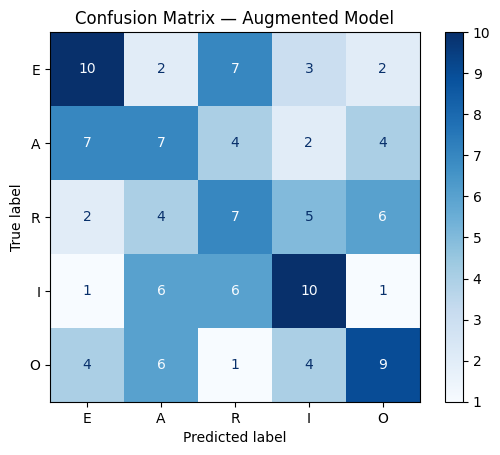

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate predictions
pred = model_augmented.predict(val_generator)
y_pred = np.argmax(pred, axis=1)

y_true = val_generator.labels

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['E', 'A', 'R', 'I', 'O'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix — Augmented Model")
plt.savefig("confusion_matrix_augmented.png")
plt.show()

